<a href="https://colab.research.google.com/github/ldlda/Fruit-Classifier-1/blob/main/cradio_head_nn_layernormal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

DRIVE_ROOT = "/content/drive/MyDrive"
PROJECT    = "cradio"  # ✅ đúng như ảnh: MyDrive/cradio/

DATASET_ROOT = os.path.join(DRIVE_ROOT, PROJECT, "dataset")
TRAIN_DIR    = os.path.join(DATASET_ROOT, "train")
VAL_DIR      = os.path.join(DATASET_ROOT, "val")
TEST_DIR     = os.path.join(DATASET_ROOT, "test")  # optional

CKPT_DIR = os.path.join(DRIVE_ROOT, PROJECT, "checkpoints_min_2class")
os.makedirs(CKPT_DIR, exist_ok=True)

print("TRAIN_DIR:", TRAIN_DIR)
print("VAL_DIR  :", VAL_DIR)
print("TEST_DIR :", TEST_DIR)
print("CKPT_DIR :", CKPT_DIR)


Mounted at /content/drive
TRAIN_DIR: /content/drive/MyDrive/cradio/dataset/train
VAL_DIR  : /content/drive/MyDrive/cradio/dataset/val
TEST_DIR : /content/drive/MyDrive/cradio/dataset/test
CKPT_DIR : /content/drive/MyDrive/cradio/checkpoints_min_2class


In [ ]:
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip -q install tqdm
print("Install done.")


Install done.


In [ ]:
import time, copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

class CFG:
    RADIO_VERSION = "c-radio_v3-b"
    IMG_SIZE = 416
    BATCH = 8
    EPOCHS = 10

    LR_BACKBONE = 1e-5
    LR_HEAD     = 1e-4
    WEIGHT_DECAY = 1e-4

    DROPOUT = 0.3
    HEAD_HIDDEN = 512
    PATIENCE = 4

    MEAN = [0.485, 0.456, 0.406]
    STD  = [0.229, 0.224, 0.225]

torch.backends.cudnn.benchmark = True


DEVICE: cuda


In [ ]:
train_tf = transforms.Compose([
    transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.05),
    transforms.ToTensor(),
    transforms.Normalize(CFG.MEAN, CFG.STD),
])

val_tf = transforms.Compose([
    transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(CFG.MEAN, CFG.STD),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=val_tf)

classes = train_ds.classes
print("Found classes:", classes)

# ImageFolder sort alphabet -> ["no_smoke","smoke"]
expected = ["no_smoke", "smoke"]
if sorted(classes) != expected:
    raise RuntimeError(f"Folder class phải đúng: {expected}. Hiện tại: {classes}")

# đảm bảo val cũng giống classes
if sorted(val_ds.classes) != expected:
    raise RuntimeError(f"VAL classes sai. VAL có: {val_ds.classes}")

num_classes = len(classes)

train_loader = DataLoader(train_ds, batch_size=CFG.BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG.BATCH, shuffle=False, num_workers=2, pin_memory=True)

print("Train:", len(train_ds), "Val:", len(val_ds))

# test loader (optional)
test_loader = None
if os.path.isdir(TEST_DIR):
    test_ds = datasets.ImageFolder(TEST_DIR, transform=val_tf)
    if sorted(test_ds.classes) != expected:
        raise RuntimeError(f"TEST classes sai. TEST có: {test_ds.classes}")
    test_loader = DataLoader(test_ds, batch_size=CFG.BATCH, shuffle=False, num_workers=2, pin_memory=True)
    print("Test :", len(test_ds))
else:
    print("TEST_DIR không tồn tại -> bỏ qua test.")


Found classes: ['no_smoke', 'smoke']
Train: 2924 Val: 365
Test : 367


In [ ]:
class RadioBackbone(nn.Module):
    def __init__(self, version: str, device: torch.device):
        super().__init__()
        print("Loading RADIO from torch.hub:", version)
        m = torch.hub.load(
            "NVlabs/RADIO",
            "radio_model",
            version=version,
            progress=True,
            skip_validation=True,
        )
        self.model = m.float().to(device)

    def forward(self, x):
        out = self.model(x, feature_fmt="NCHW")
        summary = out[0] if isinstance(out, (tuple, list)) else out
        if summary.ndim > 2:
            summary = summary.mean(dim=(2,3))
        return summary

class RadioClassifier(nn.Module):
    def __init__(self, backbone: RadioBackbone, num_classes: int, hidden: int, dropout: float):
        super().__init__()
        self.backbone = backbone
        self.num_classes = num_classes
        self.hidden = hidden
        self.dropout = dropout
        self.head = None  # lazy build

    def build_head(self, in_features: int, device: torch.device):
        self.head = nn.Sequential(
            nn.Linear(in_features, self.hidden),
            nn.LayerNorm(self.hidden),  # ✅ LayerNorm
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden, self.num_classes),
        ).to(device)

    def forward(self, x):
        feat = self.backbone(x)
        if self.head is None:
            self.build_head(feat.shape[-1], feat.device)
        return self.head(feat)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        logits = model(imgs)
        pred = logits.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
    return correct / max(total, 1)

def train_full_and_save_pt():
    backbone = RadioBackbone(CFG.RADIO_VERSION, DEVICE)
    model = RadioClassifier(backbone, num_classes=num_classes, hidden=CFG.HEAD_HIDDEN, dropout=CFG.DROPOUT).to(DEVICE)

    # build head trước để optimizer thấy params
    with torch.no_grad():
        dummy = torch.zeros(1, 3, CFG.IMG_SIZE, CFG.IMG_SIZE, device=DEVICE)
        _ = model(dummy)

    backbone_params = [p for p in model.backbone.parameters() if p.requires_grad]
    head_params     = [p for p in model.head.parameters() if p.requires_grad]

    optimizer = torch.optim.AdamW(
        [
            {"params": backbone_params, "lr": CFG.LR_BACKBONE},
            {"params": head_params,     "lr": CFG.LR_HEAD},
        ],
        weight_decay=CFG.WEIGHT_DECAY
    )

    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

    best_acc = -1.0
    best_state = None
    no_improve = 0

    for epoch in range(1, CFG.EPOCHS + 1):
        model.train()
        t0 = time.time()
        running_loss = 0.0
        seen = 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{CFG.EPOCHS}"):
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
                logits = model(imgs)
                loss = F.cross_entropy(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * imgs.size(0)
            seen += imgs.size(0)

        train_loss = running_loss / max(seen, 1)
        val_acc = evaluate(model, val_loader)

        # save last
        last_path = os.path.join(CKPT_DIR, "radio_full_last.pt")
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "classes": classes,
            "img_size": CFG.IMG_SIZE,
            "radio_version": CFG.RADIO_VERSION,
        }, last_path)

        # save best
        if val_acc > best_acc:
            best_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
            best_path = os.path.join(CKPT_DIR, "radio_full_best.pt")
            torch.save({
                "epoch": epoch,
                "model_state": best_state,
                "classes": classes,
                "img_size": CFG.IMG_SIZE,
                "radio_version": CFG.RADIO_VERSION,
            }, best_path)
        else:
            no_improve += 1

        print(f"[{epoch}] loss={train_loss:.4f}  val_acc={val_acc:.4f}  best={best_acc:.4f}  time={time.time()-t0:.1f}s")

        if no_improve >= CFG.PATIENCE:
            print("Early stopping.")
            break

    # FINAL
    final_path = os.path.join(DRIVE_ROOT, PROJECT, "final_smoke_no_smoke_full_ln.pt")
    torch.save({
        "model_state": best_state if best_state is not None else model.state_dict(),
        "classes": classes,  # ["no_smoke","smoke"]
        "img_size": CFG.IMG_SIZE,
        "radio_version": CFG.RADIO_VERSION,
        "head": {"hidden": CFG.HEAD_HIDDEN, "dropout": CFG.DROPOUT, "layernorm": True},
    }, final_path)

    print("✅ Saved FINAL to:", final_path)
    return model, final_path

model, final_pt = train_full_and_save_pt()


Loading RADIO from torch.hub: c-radio_v3-b


/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/NVlabs/RADIO/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://huggingface.co/nvidia/C-RADIOv3-B/resolve/main/c-radio_v3-b_half.pth.tar?download=true" to /root/.cache/torch/hub/checkpoints/c-radio_v3-b_half.pth.tar


100%|██████████| 521M/521M [00:01<00:00, 355MB/s]
/tmp/ipython-input-91002008.py:79: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))


Epoch 1/10:   0%|          | 0/366 [00:00<?, ?it/s]

/tmp/ipython-input-91002008.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):


[1] loss=0.2187  val_acc=0.9781  best=0.9781  time=470.1s


Epoch 2/10:   0%|          | 0/366 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b694421a3e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7b694421a3e0>
if w.is_alive():
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
         self._shutdown_workers() 
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^^^
^  ^ ^^ ^ ^  
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
  ^ ^  ^      ^^^^^^^^^^^
^  File

[2] loss=0.0533  val_acc=0.9863  best=0.9863  time=133.5s


Epoch 3/10:   0%|          | 0/366 [00:00<?, ?it/s]

[3] loss=0.0437  val_acc=0.9671  best=0.9863  time=144.9s


Epoch 4/10:   0%|          | 0/366 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b694421a3e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in:     if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7b694421a3e0>
 
  Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    if w.is_alive():^
 ^^ ^  ^^^^  ^ ^^^
^Exception ignored in:   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    <function _MultiProcessingDataLoaderIter.__del__ at 0x7b694421a3e0>^
assert self._

[4] loss=0.0347  val_acc=0.9507  best=0.9863  time=137.3s


Epoch 5/10:   0%|          | 0/366 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b694421a3e0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b694421a3e0>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
        ^ ^^ ^ ^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ 
   File "/usr/lib/pyt

[5] loss=0.0411  val_acc=0.9863  best=0.9863  time=137.9s


Epoch 6/10:   0%|          | 0/366 [00:00<?, ?it/s]

[6] loss=0.0201  val_acc=0.9890  best=0.9890  time=141.4s


Epoch 7/10:   0%|          | 0/366 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b694421a3e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b694421a3e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[7] loss=0.0208  val_acc=0.9973  best=0.9973  time=157.8s


Epoch 8/10:   0%|          | 0/366 [00:00<?, ?it/s]

[8] loss=0.0112  val_acc=0.9918  best=0.9973  time=144.8s


Epoch 9/10:   0%|          | 0/366 [00:00<?, ?it/s]

[9] loss=0.0323  val_acc=0.9808  best=0.9973  time=137.1s


Epoch 10/10:   0%|          | 0/366 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b694421a3e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b694421a3e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[10] loss=0.0224  val_acc=0.9918  best=0.9973  time=147.7s
✅ Saved FINAL to: /content/drive/MyDrive/cradio/final_smoke_no_smoke_full_ln.pt


In [ ]:
!pip -q install scikit-learn matplotlib
print("installed sklearn + matplotlib")


installed sklearn + matplotlib


=== Classification report (TEST) ===
              precision    recall  f1-score   support

    no_smoke     1.0000    1.0000    1.0000       129
       smoke     1.0000    1.0000    1.0000       238

    accuracy                         1.0000       367
   macro avg     1.0000    1.0000    1.0000       367
weighted avg     1.0000    1.0000    1.0000       367

Confusion Matrix:
 [[129   0]
 [  0 238]]


<Figure size 600x600 with 0 Axes>

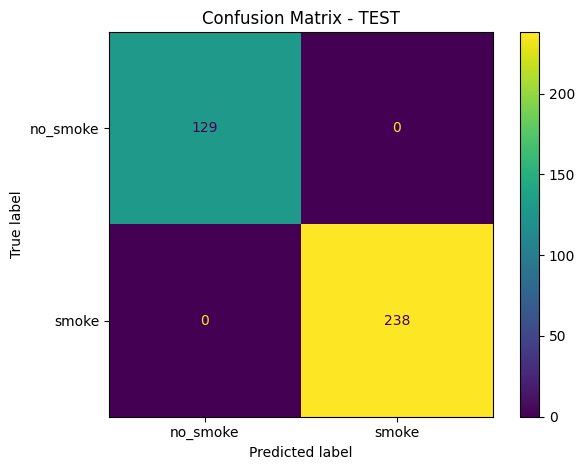

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(labels.numpy().tolist())
    return np.array(y_true), np.array(y_pred)

if test_loader is None:
    raise RuntimeError("test_loader đang None. Hãy chắc chắn bạn có folder dataset/test/ và đã tạo test_loader.")

y_true, y_pred = predict_all(model, test_loader)

print("=== Classification report (TEST) ===")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
print("Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(6, 6))
disp.plot(values_format="d")
plt.title("Confusion Matrix - TEST")
plt.tight_layout()
plt.show()


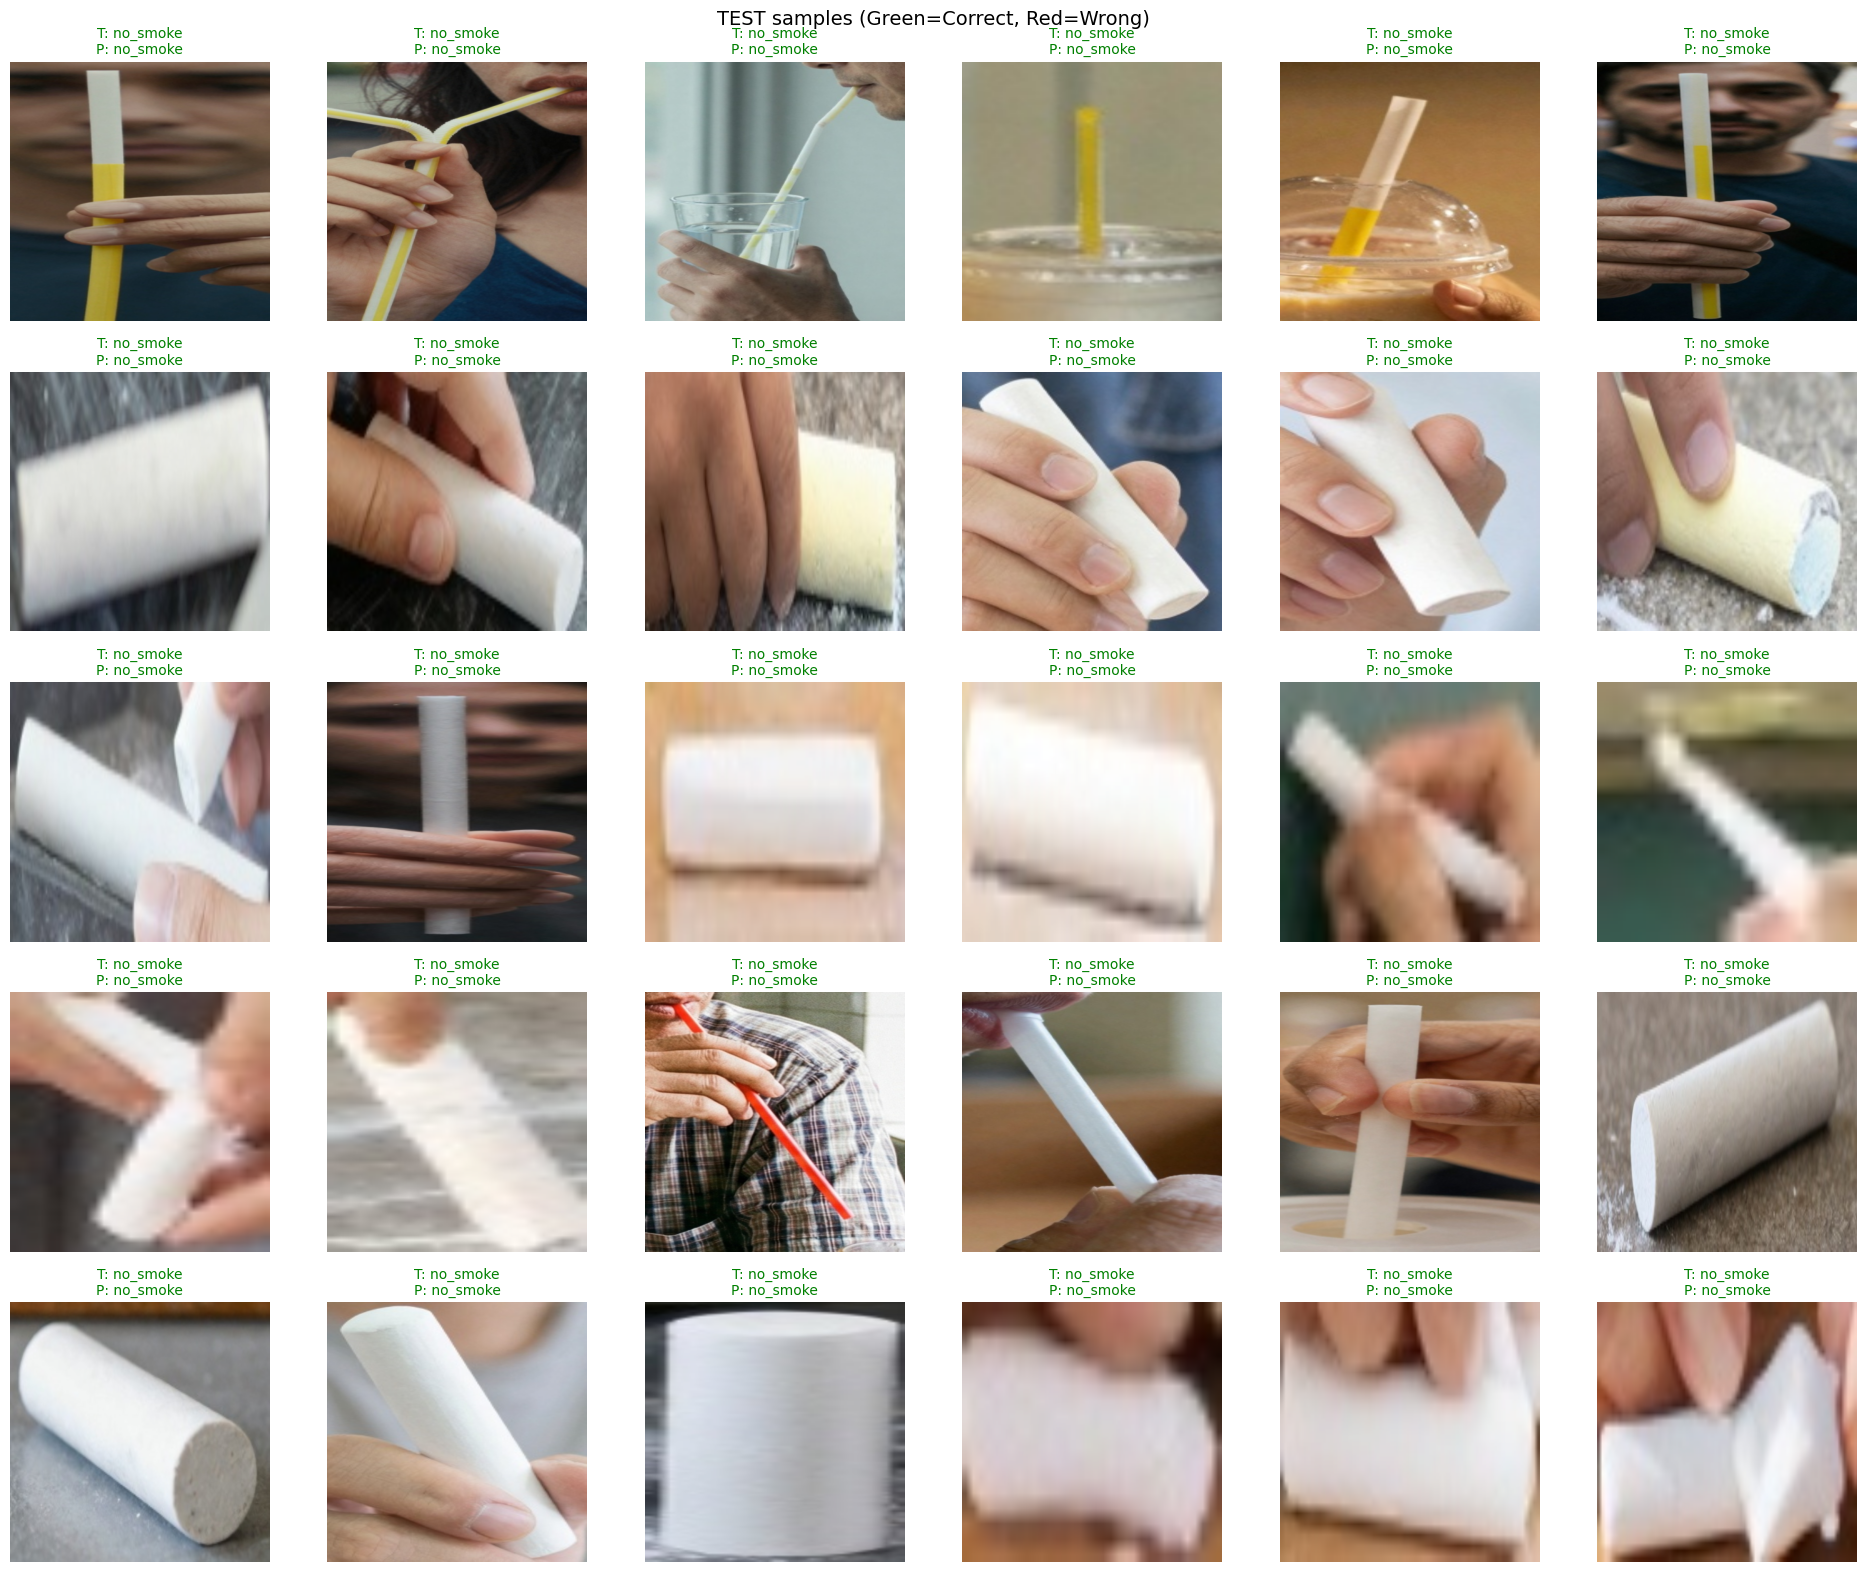

In [ ]:
import math

# helper để unnormalize ảnh về [0..1] cho dễ nhìn
MEAN = np.array(CFG.MEAN).reshape(1,1,3)
STD  = np.array(CFG.STD).reshape(1,1,3)

def unnormalize(img_tensor):
    # img_tensor: [3,H,W] torch
    img = img_tensor.detach().cpu().numpy().transpose(1,2,0)
    img = img * STD + MEAN
    img = np.clip(img, 0, 1)
    return img

@torch.no_grad()
def visualize_test_samples(model, loader, classes, num_images=24, cols=6):
    model.eval()
    shown = 0
    rows = math.ceil(num_images / cols)
    plt.figure(figsize=(3.2*cols, 3.2*rows))

    idx = 1
    for imgs, labels in loader:
        imgs_gpu = imgs.to(DEVICE, non_blocking=True)
        logits = model(imgs_gpu)
        preds = logits.argmax(dim=1).cpu()

        for i in range(imgs.size(0)):
            if shown >= num_images:
                break

            img = unnormalize(imgs[i])
            true_id = int(labels[i].item())
            pred_id = int(preds[i].item())

            ok = (true_id == pred_id)
            title_color = "green" if ok else "red"

            ax = plt.subplot(rows, cols, idx)
            ax.imshow(img)
            ax.set_title(f"T: {classes[true_id]}\nP: {classes[pred_id]}",
                         color=title_color, fontsize=10)
            ax.axis("off")

            shown += 1
            idx += 1

        if shown >= num_images:
            break

    plt.suptitle("TEST samples (Green=Correct, Red=Wrong)", fontsize=14)
    plt.tight_layout()
    plt.show()

# ví dụ: show 30 ảnh
visualize_test_samples(model, test_loader, classes, num_images=30, cols=6)


In [ ]:
@torch.no_grad()
def visualize_wrong_only(model, loader, classes, max_images=24, cols=6):
    model.eval()
    wrong_imgs = []
    wrong_true = []
    wrong_pred = []

    for imgs, labels in loader:
        imgs_gpu = imgs.to(DEVICE, non_blocking=True)
        logits = model(imgs_gpu)
        preds = logits.argmax(dim=1).cpu()

        for i in range(imgs.size(0)):
            t = int(labels[i].item())
            p = int(preds[i].item())
            if t != p:
                wrong_imgs.append(imgs[i])
                wrong_true.append(t)
                wrong_pred.append(p)
                if len(wrong_imgs) >= max_images:
                    break
        if len(wrong_imgs) >= max_images:
            break

    if len(wrong_imgs) == 0:
        print("✅ Không có ảnh sai trong phạm vi duyệt.")
        return

    rows = math.ceil(len(wrong_imgs) / cols)
    plt.figure(figsize=(3.2*cols, 3.2*rows))

    for k in range(len(wrong_imgs)):
        ax = plt.subplot(rows, cols, k+1)
        ax.imshow(unnormalize(wrong_imgs[k]))
        ax.set_title(f"T: {classes[wrong_true[k]]}\nP: {classes[wrong_pred[k]]}",
                     color="red", fontsize=10)
        ax.axis("off")

    plt.suptitle("WRONG predictions (TEST)", fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_wrong_only(model, test_loader, classes, max_images=30, cols=6)


✅ Không có ảnh sai trong phạm vi duyệt.


In [ ]:
import os, hashlib
from tqdm.auto import tqdm

def md5_file(path, chunk=1024*1024):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b: break
            h.update(b)
    return h.hexdigest()

def collect_md5(root_dir):
    hashes = {}
    for cls in ["smoke", "no_smoke"]:
        d = os.path.join(root_dir, cls)
        if not os.path.isdir(d):
            print("missing:", d); continue
        for fn in os.listdir(d):
            if not fn.lower().endswith((".jpg",".jpeg",".png")):
                continue
            p = os.path.join(d, fn)
            h = md5_file(p)
            hashes.setdefault(h, []).append(p)
    return hashes

train_h = collect_md5(TRAIN_DIR)
val_h   = collect_md5(VAL_DIR)
test_h  = collect_md5(TEST_DIR)

set_train = set(train_h.keys())
set_val   = set(val_h.keys())
set_test  = set(test_h.keys())

dup_train_test = set_train & set_test
dup_train_val  = set_train & set_val
dup_val_test   = set_val & set_test

print("Duplicate train-test:", len(dup_train_test))
print("Duplicate train-val :", len(dup_train_val))
print("Duplicate val-test  :", len(dup_val_test))

# in thử vài ảnh trùng (nếu có)
for h in list(dup_train_test)[:3]:
    print("\nDUP HASH:", h)
    for p in train_h[h][:2]:
        print("  train:", p)
    for p in test_h[h][:2]:
        print("  test :", p)


Duplicate train-test: 0
Duplicate train-val : 0
Duplicate val-test  : 0


In [ ]:
!pip -q install ultralytics

import os, shutil
from PIL import Image
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
from torchvision import transforms

# paths (đổi nếu khác)
TRAIN_DIR = "/content/drive/MyDrive/cradio/dataset/train"
VAL_DIR   = "/content/drive/MyDrive/cradio/dataset/val"
TEST_DIR  = "/content/drive/MyDrive/cradio/dataset/test"  # optional

PSEUDO_ROOT = "/content/drive/MyDrive/cradio/pseudo_cls"  # output dataset cho yolo-cls

classes = ["no_smoke", "smoke"]  # đảm bảo đúng folder tên như vậy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.1 MB/s eta 0:00:00


In [ ]:
IMG_TEACHER = 416
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

teacher_tf = transforms.Compose([
    transforms.Resize((IMG_TEACHER, IMG_TEACHER)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

def list_images(root):
    out = []
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith((".jpg",".jpeg",".png")):
                out.append(os.path.join(r, f))
    return out

@torch.no_grad()
def teacher_predict_prob(teacher, pil_img, device):
    x = teacher_tf(pil_img).unsqueeze(0).to(device)
    logits = teacher(x)
    prob = F.softmax(logits, dim=1)[0].detach().cpu()
    return prob  # tensor shape [2]

def build_pseudo_train_from_teacher(
    teacher, device,
    train_dir=TRAIN_DIR,
    pseudo_root=PSEUDO_ROOT,
    conf_thres=0.90,
    mode="replace_if_confident"  # hoặc "only_confident"
):
    # reset pseudo train
    train_out = os.path.join(pseudo_root, "train")
    if os.path.exists(train_out):
        shutil.rmtree(train_out)
    for c in classes:
        os.makedirs(os.path.join(train_out, c), exist_ok=True)

    teacher.eval()
    for p in teacher.parameters():
        p.requires_grad = False

    for true_cls in classes:
        in_dir = os.path.join(train_dir, true_cls)
        imgs = [os.path.join(in_dir, f) for f in os.listdir(in_dir)
                if f.lower().endswith((".jpg",".jpeg",".png"))]

        for pth in tqdm(imgs, desc=f"Pseudo train from {true_cls}"):
            img = Image.open(pth).convert("RGB")
            prob = teacher_predict_prob(teacher, img, device)
            pred_id = int(prob.argmax().item())
            conf = float(prob[pred_id].item())
            pred_cls = classes[pred_id]

            if mode == "only_confident":
                if conf < conf_thres:
                    continue
                out_cls = pred_cls
            else:
                # replace label if teacher confident else keep original
                out_cls = pred_cls if conf >= conf_thres else true_cls

            dst = os.path.join(train_out, out_cls, os.path.basename(pth))
            shutil.copy2(pth, dst)

    print("✅ pseudo train created:", train_out)


In [ ]:
def attach_true_split(split_name, src_split_dir, pseudo_root=PSEUDO_ROOT):
    dst = os.path.join(pseudo_root, split_name)
    if os.path.exists(dst):
        shutil.rmtree(dst)
    shutil.copytree(src_split_dir, dst)
    print(f"✅ copied true {split_name} ->", dst)

attach_true_split("val", VAL_DIR)

if os.path.isdir(TEST_DIR):
    attach_true_split("test", TEST_DIR)


✅ copied true val -> /content/drive/MyDrive/cradio/pseudo_cls/val
✅ copied true test -> /content/drive/MyDrive/cradio/pseudo_cls/test


In [ ]:
# yêu cầu: teacher là model C-RADIO của bạn
# nếu teacher của bạn tên khác, đổi lại
teacher = model
device = next(teacher.parameters()).device

build_pseudo_train_from_teacher(
    teacher=teacher,
    device=device,
    train_dir=TRAIN_DIR,
    pseudo_root=PSEUDO_ROOT,
    conf_thres=0.90,
    mode="replace_if_confident"  # dễ và ổn
)

print("PSEUDO_ROOT ready:", PSEUDO_ROOT)


Pseudo train from no_smoke:   0%|          | 0/1025 [00:00<?, ?it/s]

Pseudo train from smoke:   0%|          | 0/1899 [00:00<?, ?it/s]

✅ pseudo train created: /content/drive/MyDrive/cradio/pseudo_cls/train
PSEUDO_ROOT ready: /content/drive/MyDrive/cradio/pseudo_cls


In [ ]:
from ultralytics import YOLO

y = YOLO("yolo11n-cls.pt")  # nhẹ
y.train(
    data=PSEUDO_ROOT,   # folder có train/val
    imgsz=224,          # cls thường 224 là ok, nhẹ
    epochs=30,
    batch=64,
    device=0
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/cradio/pseudo_cls, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.6±0.2 ms, read: 8.1±5.5 MB/s, size: 12.7 KB)
train: Scanning /content/drive/MyDrive/cradio/pseudo_cls/train... 2918 images, 6 corrupt: 100% ━━━━━━━━━━━━ 2924/2924 157.8it/s 18.5s
train: /content/drive/MyDrive/cradio/pseudo_cls/train/no_smoke/Full-body_photo_of_elderl_8ebb05_obj1_cls0.jpg: ignoring corrupt image/label: image size (8, 51) <10 pixels
train: /content/drive/MyDrive/cradio/pseudo_cls/train/no_smoke/Medium_photo_of_elderly_m_2cc216_obj0_cls0.jpg: ignoring corrupt image/label: image size (9, 41) <10 pixels
train: /content/drive/MyDrive/cradio/pseudo_cls/train/no_smoke/Overhead_photo_of_elderly_234c29_obj1_cls0.jpg: ignoring corrupt image/label: image size (9, 29) <10 pixels
train: /content/drive/MyDrive/cradio/pseudo_cls/train/smoke/Adult_woman_walking_along_6a0343_obj1_cls0.jpg: ignoring corrupt image/label: image size (20, 8) <10 pixels
train: /content/drive/MyDrive/cradio/pseudo_cls/train/smoke/Middle-aged_man_leaning

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       1/30      1.86G     0.7116         64        224: 0% ──────────── 0/46  32.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       1/30      1.88G      0.726         64        224: 2% ──────────── 1/46 1.5it/s 32.4s<30.2s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(t

       1/30      1.88G     0.3252         38        224: 100% ━━━━━━━━━━━━ 46/46 1.8s/it 1:21
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 1.3it/s 2.3s
                   all      0.964          1

      Epoch    GPU_mem       loss  Instances       Size
       2/30      1.89G     0.0753         64        224: 2% ──────────── 1/46 2.6it/s 0.2s<17.4s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       2/30      1.91G     0.1617         38        224: 100% ━━━━━━━━━━━━ 46/46 2.0it/s 23.1s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 28.7it/s 0.1s
                   all      0.921          1

      Epoch    GPU_mem       loss  Instances       Size
       3/30      1.91G     0.1904         64        224: 2% ──────────── 1/46 2.9it/s 1.3s<15.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       3/30      1.91G     0.2205         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.4s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 27.6it/s 0.1s
                   all      0.921          1

      Epoch    GPU_mem       loss  Instances       Size
       4/30      1.91G     0.2581         64        224: 0% ──────────── 0/46  1.4s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       4/30      1.92G      0.246         38        224: 100% ━━━━━━━━━━━━ 46/46 1.5it/s 29.9s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 17.9it/s 0.2s
                   all      0.951          1

      Epoch    GPU_mem       loss  Instances       Size
       5/30      1.92G     0.1587         64        224: 0% ──────────── 0/46  1.4s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       5/30      1.93G     0.1845         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 29.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 29.1it/s 0.1s
                   all      0.877          1

      Epoch    GPU_mem       loss  Instances       Size
       6/30      1.93G     0.1336         64        224: 2% ──────────── 1/46 2.4it/s 1.5s<18.9s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       6/30      1.94G     0.1536         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 29.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 25.6it/s 0.1s
                   all      0.964          1

      Epoch    GPU_mem       loss  Instances       Size
       7/30      1.94G    0.07729         64        224: 0% ──────────── 0/46  1.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       7/30      1.95G     0.1365         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 28.2it/s 0.1s
                   all      0.951          1

      Epoch    GPU_mem       loss  Instances       Size
       8/30      1.95G      0.125         64        224: 0% ──────────── 0/46  1.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       8/30      1.96G     0.1281         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.8s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 27.9it/s 0.1s
                   all      0.964          1

      Epoch    GPU_mem       loss  Instances       Size
       9/30      1.96G     0.1418         64        224: 0% ──────────── 0/46  1.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       9/30      1.97G     0.1279         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 23.6it/s 0.1s
                   all      0.951          1

      Epoch    GPU_mem       loss  Instances       Size
      10/30      1.97G     0.1949         64        224: 0% ──────────── 0/46  2.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      10/30      1.97G     0.1035         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 29.5s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 27.3it/s 0.1s
                   all      0.915          1

      Epoch    GPU_mem       loss  Instances       Size
      11/30      1.97G    0.08343         64        224: 0% ──────────── 0/46  1.7s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      11/30      1.98G     0.1096         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.9s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 26.8it/s 0.1s
                   all      0.967          1

      Epoch    GPU_mem       loss  Instances       Size
      12/30      1.98G    0.07978         64        224: 0% ──────────── 0/46  1.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      12/30      1.99G    0.08739         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.5s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 25.7it/s 0.1s
                   all      0.973          1

      Epoch    GPU_mem       loss  Instances       Size
      13/30      1.99G    0.06582         64        224: 0% ──────────── 0/46  1.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      13/30         2G    0.09424         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.4s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 30.3it/s 0.1s
                   all      0.984          1

      Epoch    GPU_mem       loss  Instances       Size
      14/30         2G    0.09886         64        224: 2% ──────────── 1/46 2.9it/s 1.4s<15.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      14/30      2.01G    0.08139         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.5s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 25.8it/s 0.1s
                   all      0.981          1

      Epoch    GPU_mem       loss  Instances       Size
      15/30      2.01G    0.05805         64        224: 2% ──────────── 1/46 2.7it/s 1.4s<16.6s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      15/30      2.02G    0.07641         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.6s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 28.0it/s 0.1s
                   all      0.956          1

      Epoch    GPU_mem       loss  Instances       Size
      16/30      2.02G     0.1126         64        224: 0% ──────────── 0/46  1.8s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      16/30      2.03G    0.06262         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 29.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 24.3it/s 0.1s
                   all      0.973          1

      Epoch    GPU_mem       loss  Instances       Size
      17/30      2.03G    0.07247         64        224: 2% ──────────── 1/46 2.8it/s 2.2s<15.9s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      17/30      2.04G    0.06447         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 29.3s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 29.4it/s 0.1s
                   all      0.937          1

      Epoch    GPU_mem       loss  Instances       Size
      18/30      2.04G     0.1089         64        224: 2% ──────────── 1/46 2.8it/s 1.5s<16.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      18/30      2.04G    0.07489         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.9s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 26.3it/s 0.1s
                   all      0.981          1

      Epoch    GPU_mem       loss  Instances       Size
      19/30      2.04G    0.03412         64        224: 0% ──────────── 0/46  1.4s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      19/30      2.05G    0.06022         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.7s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 25.4it/s 0.1s
                   all      0.981          1

      Epoch    GPU_mem       loss  Instances       Size
      20/30      2.05G    0.06216         64        224: 0% ──────────── 0/46  1.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      20/30      2.06G     0.0556         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 29.7it/s 0.1s
                   all      0.986          1

      Epoch    GPU_mem       loss  Instances       Size
      21/30      2.06G    0.03004         64        224: 0% ──────────── 0/46  1.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      21/30      2.07G    0.05478         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 25.6it/s 0.1s
                   all      0.984          1

      Epoch    GPU_mem       loss  Instances       Size
      22/30      2.07G    0.01396         64        224: 0% ──────────── 0/46  2.0s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      22/30      2.08G    0.04973         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.8s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 20.5it/s 0.1s
                   all      0.984          1

      Epoch    GPU_mem       loss  Instances       Size
      23/30      2.08G    0.01878         64        224: 0% ──────────── 0/46  1.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      23/30      2.09G    0.04107         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.6s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 25.7it/s 0.1s
                   all      0.981          1

      Epoch    GPU_mem       loss  Instances       Size
      24/30      2.09G     0.1157         64        224: 0% ──────────── 0/46  0.6s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      24/30       2.1G     0.0414         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.2s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 27.4it/s 0.1s
                   all      0.989          1

      Epoch    GPU_mem       loss  Instances       Size
      25/30       2.1G    0.05297         64        224: 0% ──────────── 0/46  1.0s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      25/30      2.11G    0.03396         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.8s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 25.9it/s 0.1s
                   all      0.984          1

      Epoch    GPU_mem       loss  Instances       Size
      26/30      2.11G    0.03553         64        224: 0% ──────────── 0/46  1.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      26/30      2.12G    0.02961         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.6s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 27.3it/s 0.1s
                   all      0.989          1

      Epoch    GPU_mem       loss  Instances       Size
      27/30      2.12G    0.02329         64        224: 2% ──────────── 1/46 2.4it/s 1.4s<18.6s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      27/30      2.12G    0.03051         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 29.1s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 22.4it/s 0.1s
                   all      0.992          1

      Epoch    GPU_mem       loss  Instances       Size
      28/30      2.12G    0.03838         64        224: 0% ──────────── 0/46  2.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      28/30      2.13G    0.02817         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 29.6s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 22.1it/s 0.1s
                   all      0.989          1

      Epoch    GPU_mem       loss  Instances       Size
      29/30      2.13G   0.008991         64        224: 2% ──────────── 1/46 2.5it/s 1.3s<17.8s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      29/30      2.14G    0.02911         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 29.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 29.4it/s 0.1s
                   all      0.992          1

      Epoch    GPU_mem       loss  Instances       Size
      30/30      2.14G   0.006054         64        224: 0% ──────────── 0/46  1.4s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      30/30      2.15G    0.02148         38        224: 100% ━━━━━━━━━━━━ 46/46 1.6it/s 28.9s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 31.6it/s 0.1s
                   all      0.992          1

30 epochs completed in 0.259 hours.
Optimizer stripped from /content/runs/classify/train/weights/last.pt, 3.2MB
Optimizer stripped from /content/runs/classify/train/weights/best.pt, 3.2MB

Validating /content/runs/classify/train/weights/best.pt...
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
train: /content/drive/MyDrive/cradio/pseudo_cls/train... found 2924 images in 2 classes ✅ 
val: /content/drive/MyDrive/cradio/pseudo_cls/val... found 365 images in 2 classes ✅ 
test: /content/drive/MyDrive/cradio/pseudo_cls/test... found 367 images in 2 classes ✅ 
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 9.8it/s 0.3s
              

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b679cae19d0>
curves: []
curves_results: []
fitness: 0.9958904087543488
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9917808175086975, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9958904087543488}
save_dir: PosixPath('/content/runs/classify/train')
speed: {'preprocess': 0.06916024109433574, 'inference': 0.6227242301376887, 'loss': 8.690136906209287e-05, 'postprocess': 0.00014354794336824154}
task: 'classify'
top1: 0.9917808175086975
top5: 1.0

In [ ]:
!pip -q install scikit-learn matplotlib

import os, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

# ==== đường dẫn weights YOLO-CLS ====
YOLO_CLS_WEIGHTS = "/content/runs/classify/train/weights/best.pt"  # nếu khác thì sửa
ycls = YOLO(YOLO_CLS_WEIGHTS)

# ==== test dir (dùng test thật của bạn) ====
TEST_DIR = "/content/drive/MyDrive/cradio/dataset/test"  # hoặc /cradio/pseudo_cls/test nếu bạn copy test vào pseudo

# classes theo folder (đúng như bạn dùng trước)
CLASSES = ["no_smoke", "smoke"]

def list_test_images(test_dir, classes=CLASSES):
    items = []
    for ci, c in enumerate(classes):
        d = os.path.join(test_dir, c)
        if not os.path.isdir(d):
            raise RuntimeError(f"Missing folder: {d}")
        for fn in os.listdir(d):
            if fn.lower().endswith((".jpg",".jpeg",".png")):
                items.append((os.path.join(d, fn), ci))
    return items

test_items = list_test_images(TEST_DIR)
print("Test images:", len(test_items))
print("Sample:", test_items[0])


Test images: 367
Sample: ('/content/drive/MyDrive/cradio/dataset/test/no_smoke/Cinematic_medium_close-up_017ba0_obj0_cls0.jpg', 0)


Predict test:   0%|          | 0/367 [00:00<?, ?it/s]

✅ TEST Accuracy: 0.9836512261580381

=== Classification report ===
              precision    recall  f1-score   support

    no_smoke     0.9920    0.9612    0.9764       129
       smoke     0.9793    0.9958    0.9875       238

    accuracy                         0.9837       367
   macro avg     0.9857    0.9785    0.9819       367
weighted avg     0.9838    0.9837    0.9836       367



<Figure size 600x600 with 0 Axes>

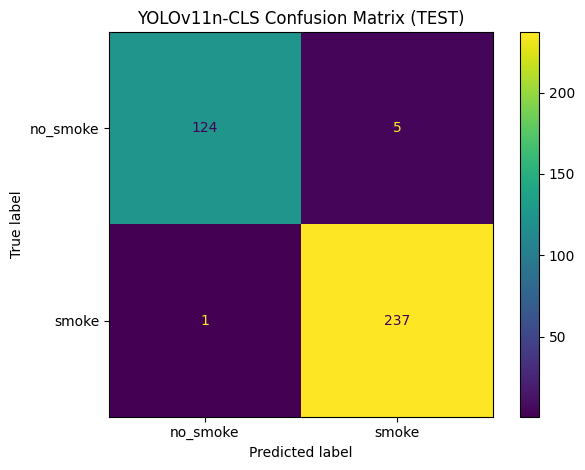

In [ ]:
def yolo_cls_predict_one(model, img_path):
    # Ultralytics classify: model(img_path)[0].probs.top1 / top1conf
    r = model(img_path, verbose=False)[0]
    pred_id = int(r.probs.top1)
    conf = float(r.probs.top1conf)
    # full probs
    probs = r.probs.data.detach().cpu().numpy()  # shape [num_classes]
    return pred_id, conf, probs

y_true, y_pred, y_conf = [], [], []
probs_all = []

for p, gt in tqdm(test_items, desc="Predict test"):
    pred, conf, probs = yolo_cls_predict_one(ycls, p)
    y_true.append(gt)
    y_pred.append(pred)
    y_conf.append(conf)
    probs_all.append(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
print("✅ TEST Accuracy:", acc)

print("\n=== Classification report ===")
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
plt.figure(figsize=(6,6))
disp.plot(values_format="d")
plt.title("YOLOv11n-CLS Confusion Matrix (TEST)")
plt.tight_layout()
plt.show()


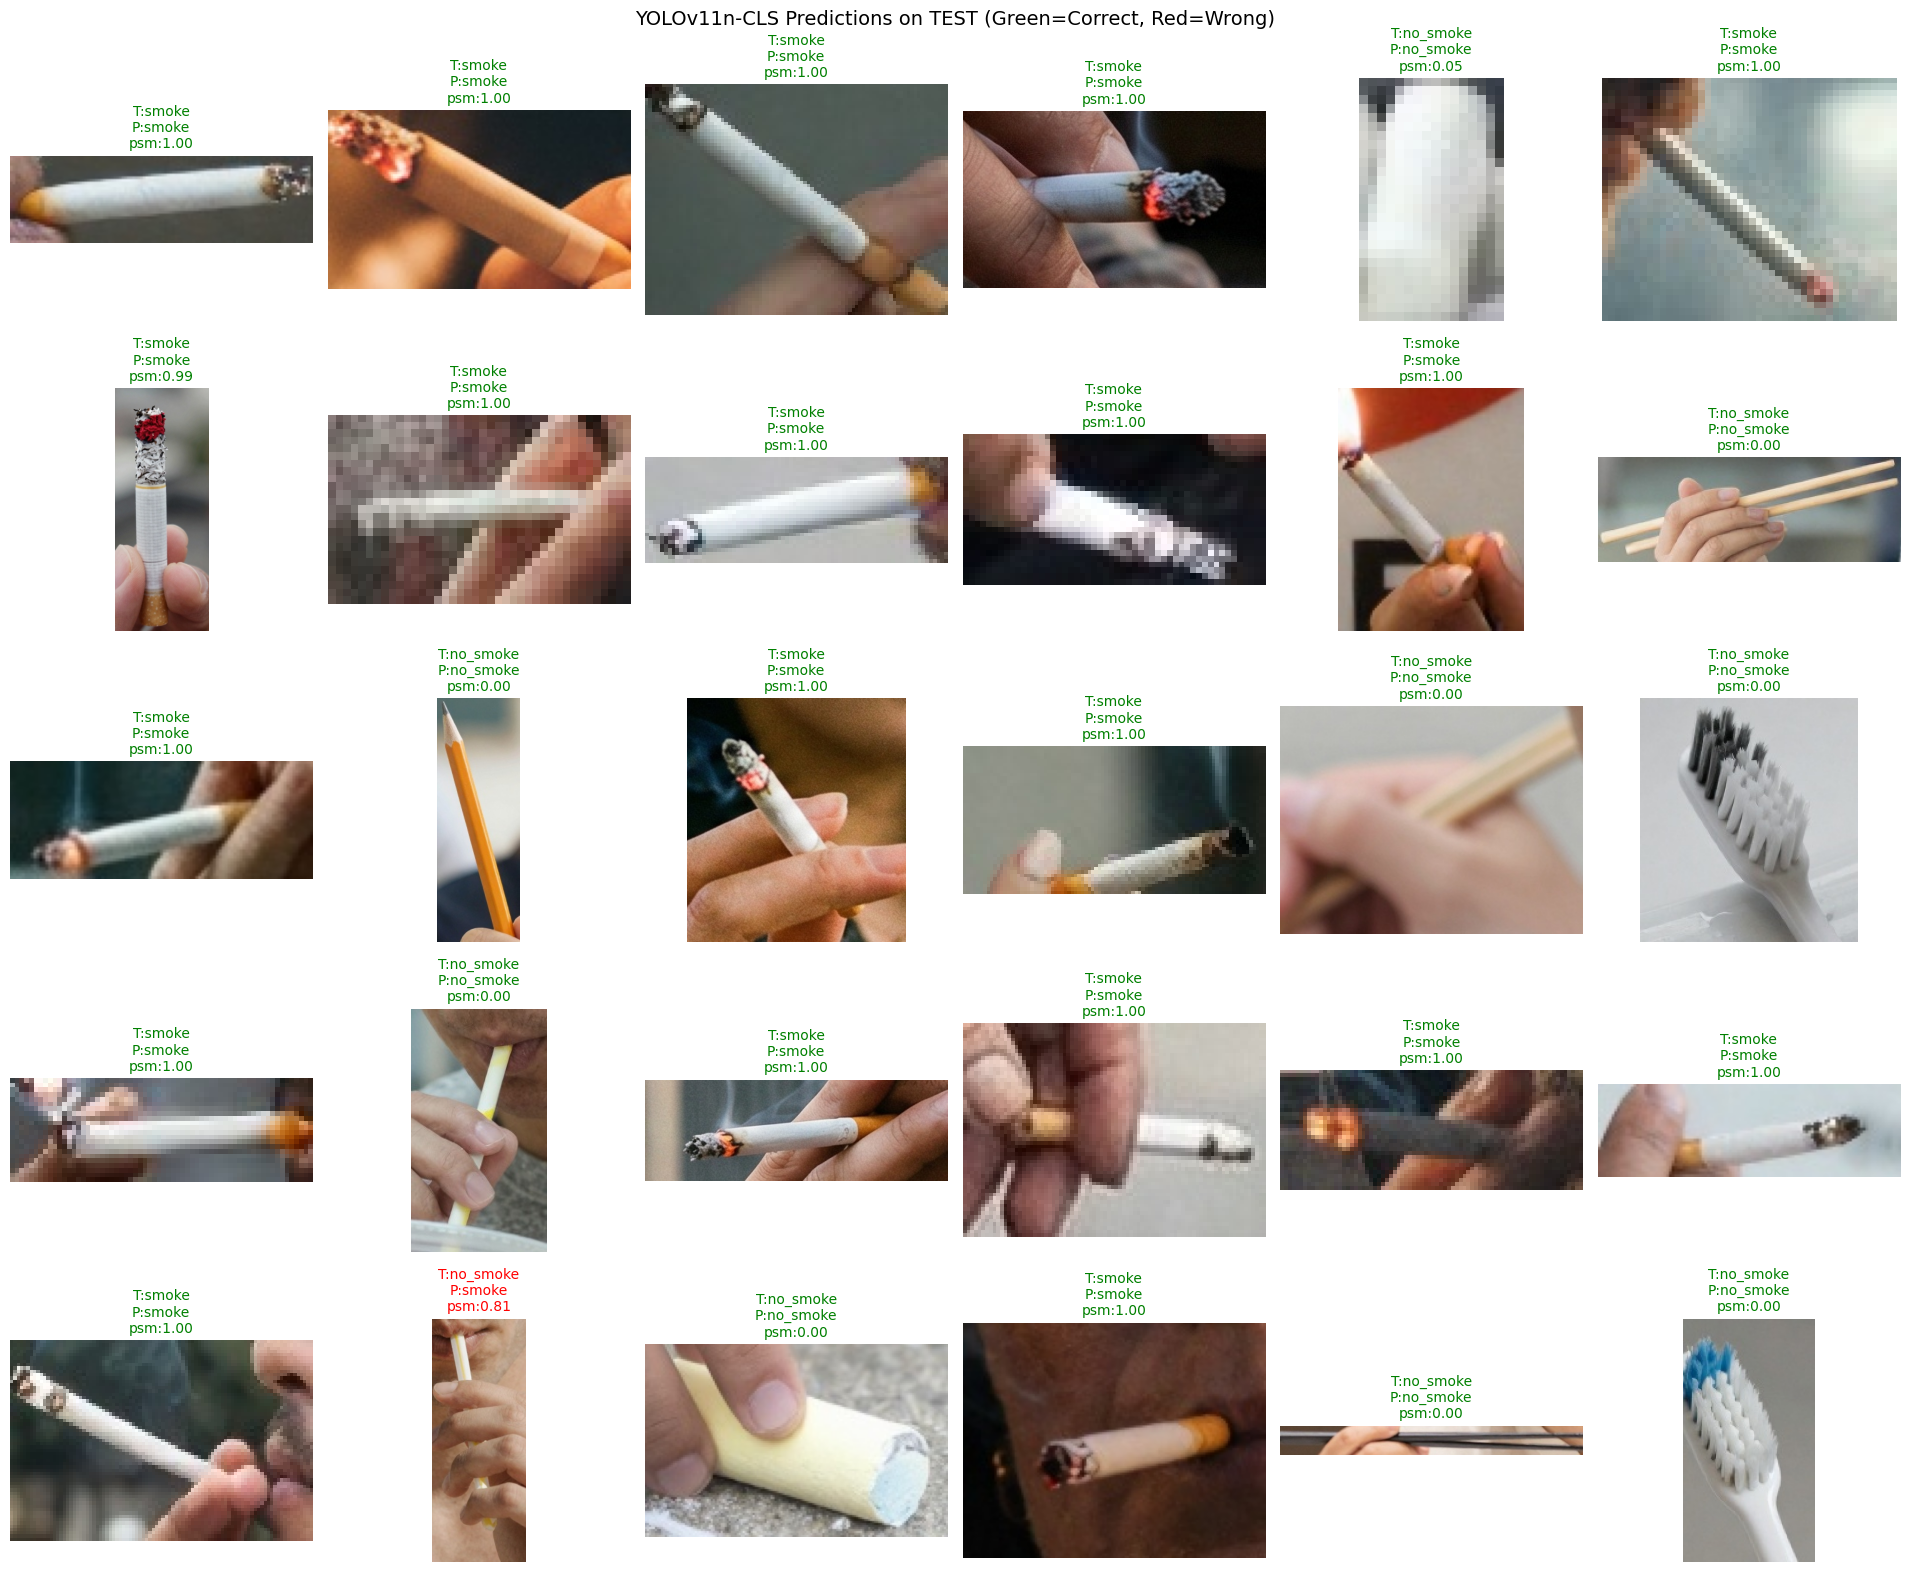

In [ ]:
import math

def show_grid_predictions(items, y_true_arr, y_pred_arr, probs_list, classes=CLASSES, n=24, cols=6, seed=42):
    random.seed(seed)
    idxs = list(range(len(items)))
    random.shuffle(idxs)
    idxs = idxs[:n]

    rows = math.ceil(n / cols)
    plt.figure(figsize=(3.2*cols, 3.2*rows))

    for k, idx in enumerate(idxs, start=1):
        p, gt = items[idx]
        pred = int(y_pred_arr[idx])
        probs = probs_list[idx]
        p_smoke = float(probs[classes.index("smoke")]) if "smoke" in classes else float(np.max(probs))

        img = Image.open(p).convert("RGB")
        ax = plt.subplot(rows, cols, k)
        ax.imshow(img)

        ok = (gt == pred)
        color = "green" if ok else "red"
        ax.set_title(f"T:{classes[gt]}\nP:{classes[pred]}\npsm:{p_smoke:.2f}",
                     color=color, fontsize=10)
        ax.axis("off")

    plt.suptitle("YOLOv11n-CLS Predictions on TEST (Green=Correct, Red=Wrong)", fontsize=14)
    plt.tight_layout()
    plt.show()

show_grid_predictions(test_items, y_true, y_pred, probs_all, n=30, cols=6)


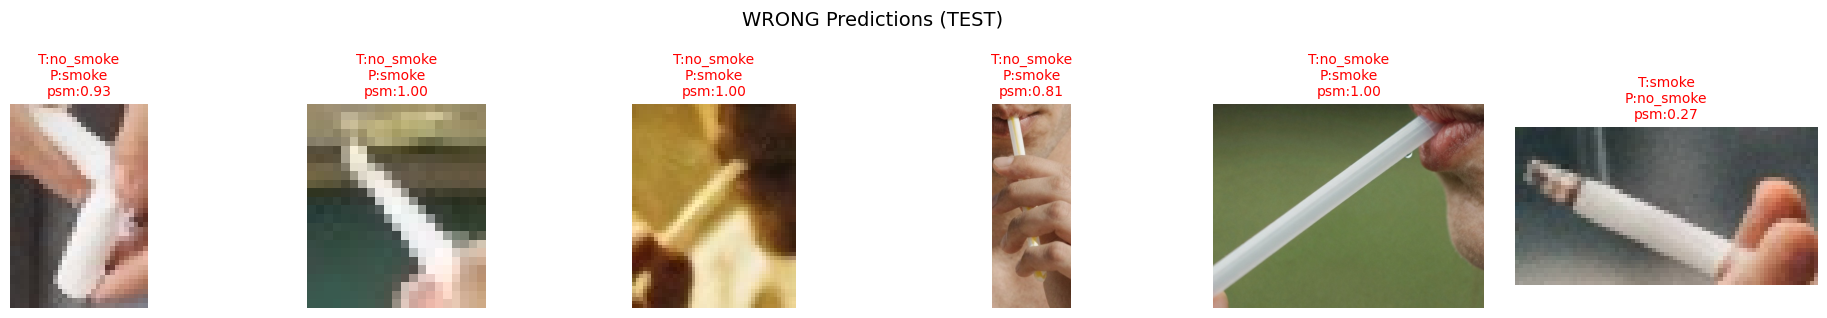

In [ ]:
def show_wrong_only(items, y_true_arr, y_pred_arr, probs_list, classes=CLASSES, max_images=30, cols=6):
    wrong = [i for i in range(len(items)) if int(y_true_arr[i]) != int(y_pred_arr[i])]
    if len(wrong) == 0:
        print("✅ Không có ảnh sai trong TEST.")
        return

    wrong = wrong[:max_images]
    rows = math.ceil(len(wrong) / cols)
    plt.figure(figsize=(3.2*cols, 3.2*rows))

    for k, idx in enumerate(wrong, start=1):
        p, gt = items[idx]
        pred = int(y_pred_arr[idx])
        probs = probs_list[idx]
        p_smoke = float(probs[classes.index("smoke")]) if "smoke" in classes else float(np.max(probs))

        img = Image.open(p).convert("RGB")
        ax = plt.subplot(rows, cols, k)
        ax.imshow(img)
        ax.set_title(f"T:{classes[gt]}\nP:{classes[pred]}\npsm:{p_smoke:.2f}",
                     color="red", fontsize=10)
        ax.axis("off")

    plt.suptitle("WRONG Predictions (TEST)", fontsize=14)
    plt.tight_layout()
    plt.show()

show_wrong_only(test_items, y_true, y_pred, probs_all, max_images=36, cols=6)
